In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage
import os
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

In [2]:
def plot_grad_dist(metric_name,
                   p_vals, 
                   dataset_name, 
                   grad_type,
                   method_arr,
                   method_names,
                   downstream_acc_type,
                   variance_type,
                   together = False):
    
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['font.size'] = 20
    
    result_dir = f'gradient_similarity/{dataset_name}/plots'
    if not os.path.exists(result_dir): os.mkdir(result_dir)
    
    if together: # just create 1 subplot for everything
        fig, axs = plt.subplots(1, 2, figsize=(20, 10))
    
    num_methods = len(method_arr)
    if not together:
        fig, axs = plt.subplots(num_methods, 2, figsize=(20, 4*num_methods))  # Adjust subplot size as needed

    for method_index, method in enumerate(method_arr):
        #if not together:
        #    fig, axs = plt.subplots(1, 2, figsize=(20, 4))  # Adjust subplot size as needed
        
        if (num_methods == 1) or together:  # Check if there are multiple metrics to avoid indexing error on axs
            ax = axs
        else:
            ax = axs[method_index]
        
        method_name = method_names[method_index]

        # load accuracies
        acc_block = np.load(f'gradient_similarity/{dataset_name}/{method}/acc_block.npy')
        # acc_block is (p_val x num_tasks) of downstream acc performance
        if downstream_acc_type == 'last':
            acc_arr = acc_block[:, -1]
        elif downstream_acc_type == 'avg':
            acc_arr = np.mean(acc_block, axis = -1)
        else:
            print('invalid downstream acc type')
            assert False

        # load gradients (num_p, num_runs, num_ideal_models, num_tasks-1, num_grad_files)
        grad_block = np.load(f'gradient_similarity/{dataset_name}/{method}/{metric_name}/{grad_type}_gradient_comp.npy')

        avg_over_grad_files = np.mean(grad_block, axis = -1)
        avg_over_tasks = np.mean(avg_over_grad_files, axis = -1)

        if variance_type == 'dataset':
            avg_grad_block = avg_over_tasks[:,:,0]
            # avg over runs
            grad_dists = np.mean(avg_grad_block, axis = -1)
            grad_stds = np.std(avg_grad_block, axis = -1)
        elif variance_type == 'weight':
            avg_grad_block = avg_over_tasks[:,0,:]
            # avg over ideal models
            grad_dists = np.mean(avg_grad_block, axis = -1)
            grad_stds = np.std(avg_grad_block, axis = -1)
        elif variance_type == 'all':
            grad_dists = np.mean(np.mean(avg_over_tasks, axis = -1), axis = -1)
            grad_stds = (np.std(avg_over_tasks[:,:,0], axis = -1)**2 + np.std(avg_over_tasks[:,0,:], axis = -1)**2)**(1/2)
        
        ax[1].set_xlim(0, 1)
        ax[0].plot(p_vals, grad_dists, marker='o', label = method_name)
        if not together:
            ax[0].fill_between(p_vals, grad_dists - grad_stds, grad_dists + grad_stds, alpha=0.2)
        #ax[0].set_xlabel('p values')
        #ax[0].set_ylabel('Gradient distance')
        ax[0].set_xscale('log')
        if not together:
            ax[0].set_title(f'{metric_name} for {method_name}')

        ax[1].plot(acc_arr, grad_dists, marker='o', label = method_name)
        if not together:
            ax[1].fill_between(acc_arr, grad_dists - grad_stds, grad_dists + grad_stds, alpha=0.2)
        #ax[1].set_xlabel('Downstream accuracy')
        #ax[1].set_ylabel('Gradient distance')
        if not together:
            ax[1].set_title(f'{metric_name} for {method_name}')
            
        if method_index == len(method_arr) -1: # plot for last row
            ax[0].set_xlabel('p values')
            ax[1].set_xlabel('Downstream accuracy')
        elif method_index == 0:
            ax[0].set_ylabel('Gradient distance')
            
            
    
    # save_path = f'{save_path}/task_{task}/{fig_name_prefix}'
    # os.makedirs(save_path, exist_ok=True)

    # plt.tight_layout()
    # if plot_acc: # plotting against accuracy
    #     img_name = f'{save_path}/{dataset_name}_acc.png'
    # else: # plotting against p_values
    #     img_name = f'{save_path}/{dataset_name}_p.png'
    # plt.savefig(img_name)
    if not together:
        plt.tight_layout()
        plt.savefig(f'{result_dir}/mem_indiv.png')
        plt.show()
    else:
        axs[0].legend()
        axs[1].legend()
        
        axs[0].set_title(f'{metric_name} vs P-value')
        axs[1].set_title(f'{metric_name} vs Downstream Accuracy')
        plt.tight_layout()
        plt.savefig(f'{result_dir}/mem_comp.png')
        plt.show()

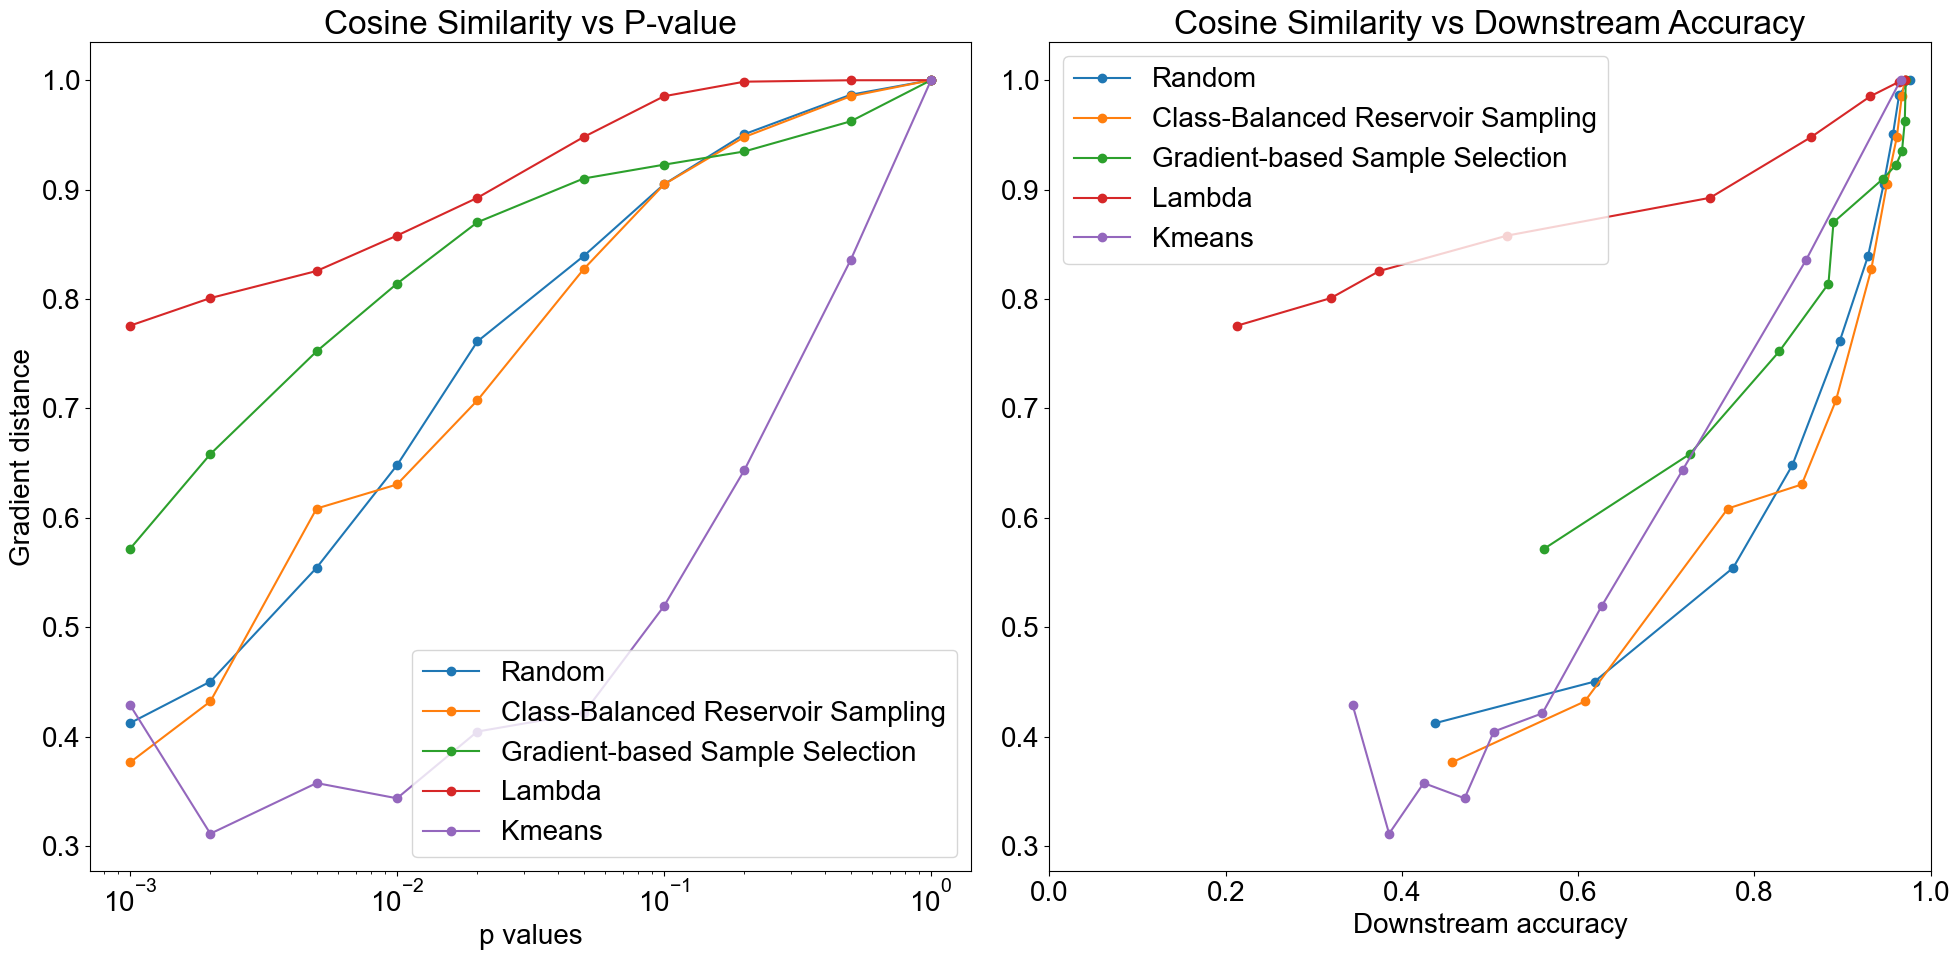

In [31]:
metric_name = 'Cosine Similarity'
p_values = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]
dataset_name = 'mnist_split'
grad_type = 'past'
method_arr = ['random', 'class_balanced', 'GSS', 'lambda', 'kmeans']
method_names = ['Random', "Class-Balanced Reservoir Sampling", "Gradient-based Sample Selection", "Lambda", 'Kmeans']
downstream_acc_type = 'last' # can be last or avg
variance_type = 'dataset' # can be dataset, weight, or all
together = True

plot_grad_dist(metric_name = metric_name,
               p_vals = p_values, 
               dataset_name = dataset_name, 
               grad_type = grad_type,
               method_arr = method_arr,
               method_names = method_names,
               downstream_acc_type = downstream_acc_type,
               variance_type = variance_type,
               together = together)

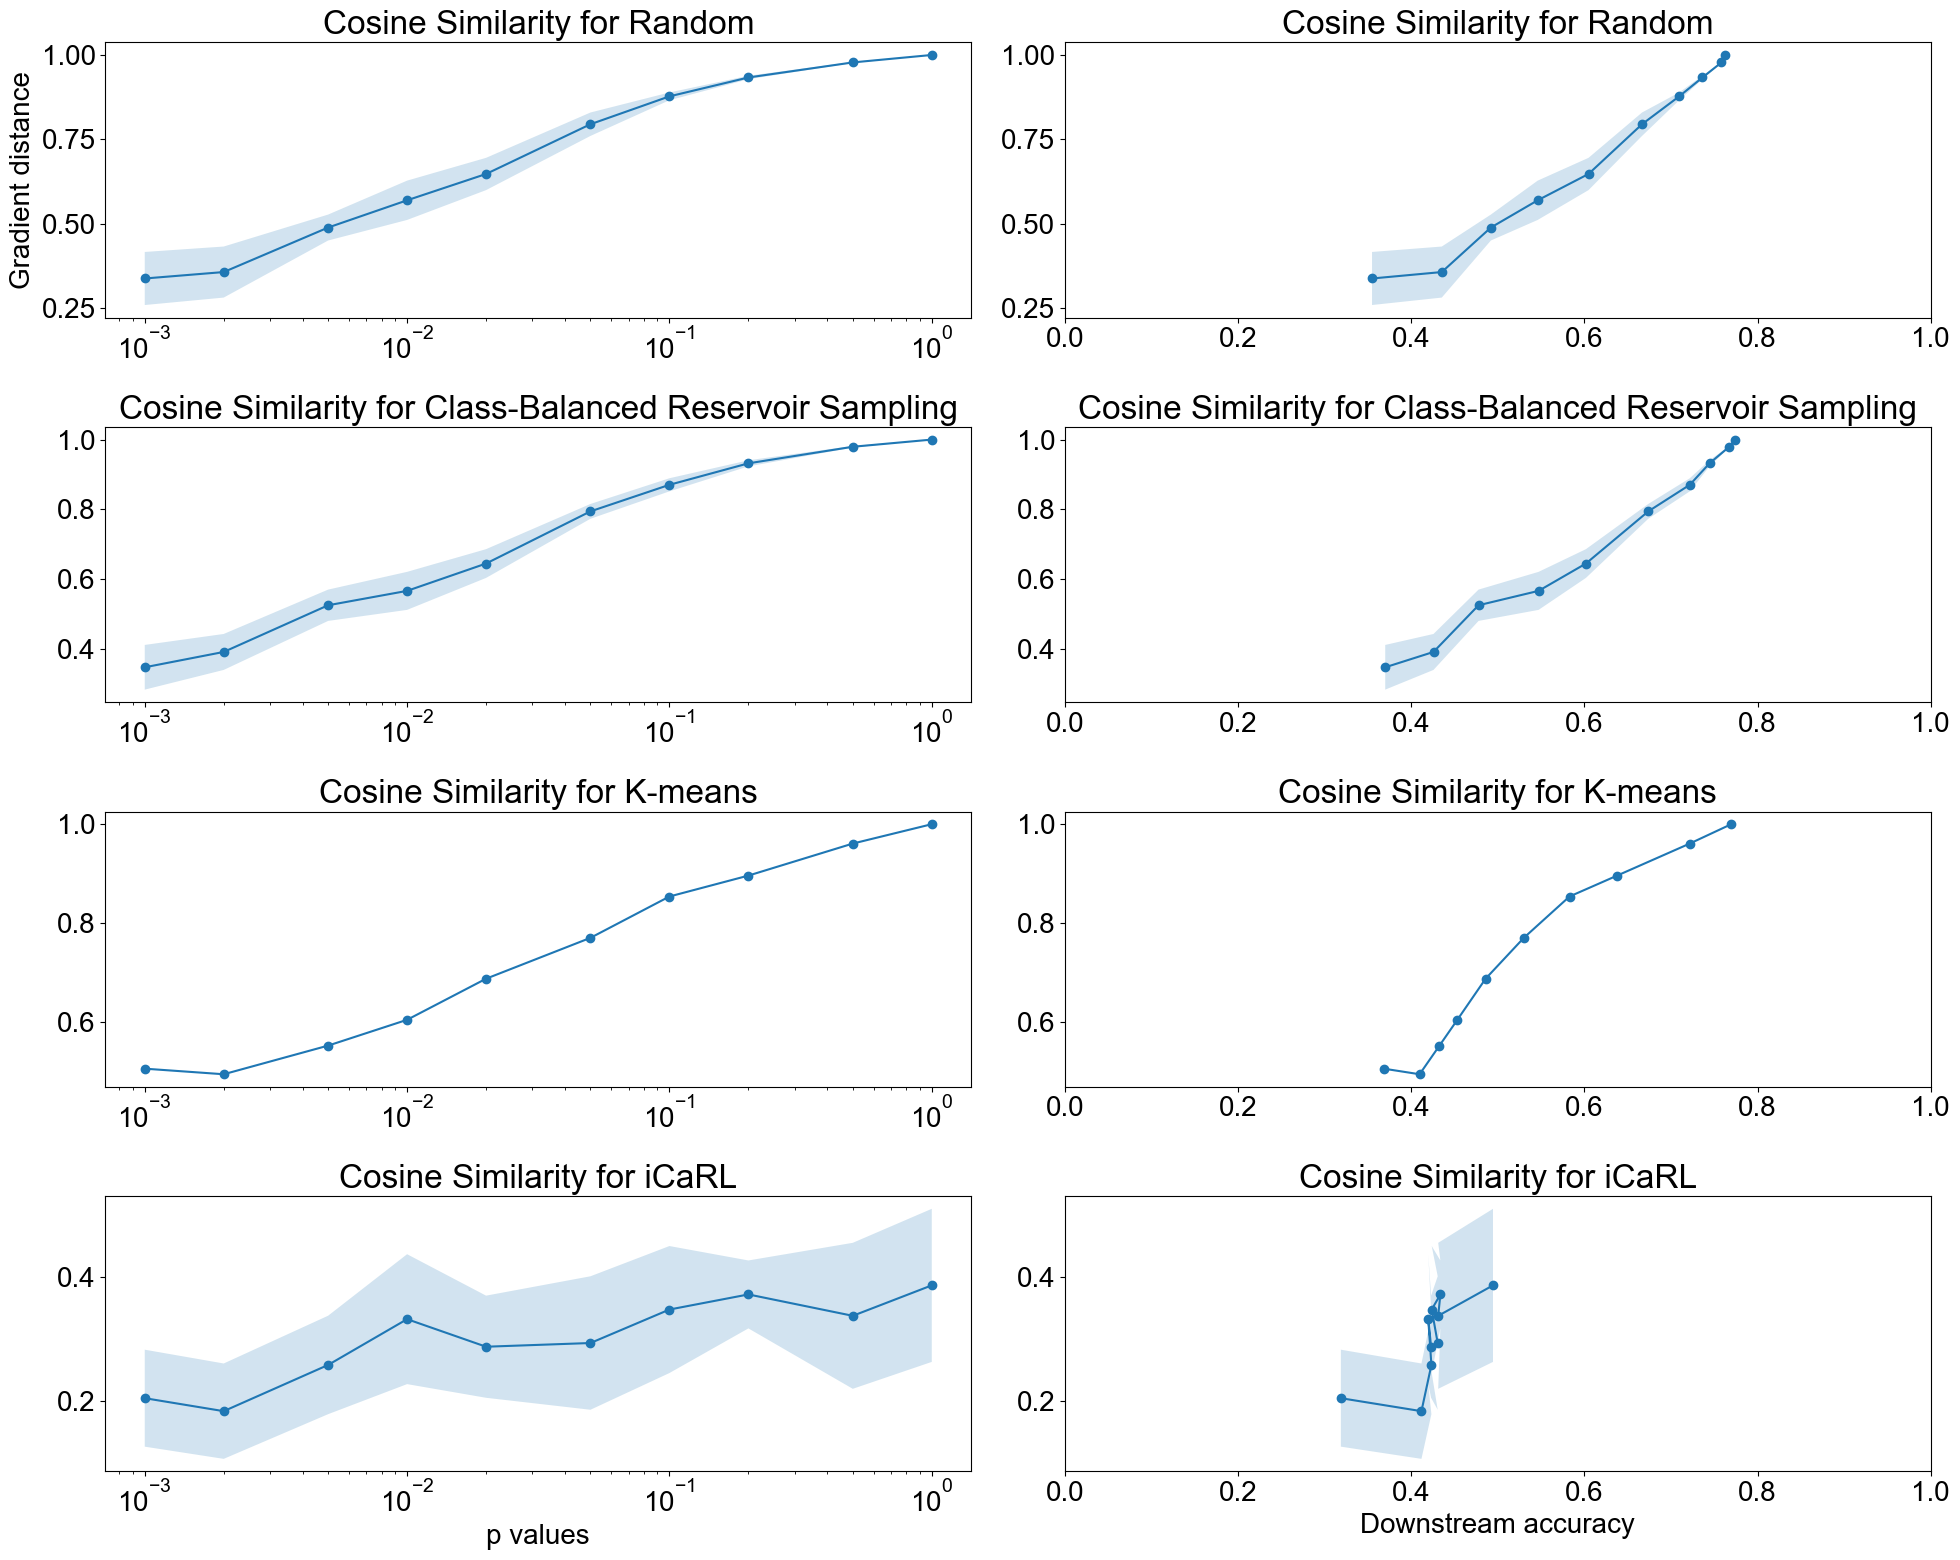

In [40]:
metric_name = 'Cosine Similarity'
p_values = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]
dataset_name = 'cifar10_split'
grad_type = 'past'
method_arr = ['random', 'class_balanced', 'kmeans' ,'iCaRL']
method_names = ['Random', "Class-Balanced Reservoir Sampling", "K-means", "iCaRL"]
downstream_acc_type = "avg" #'last' # can be last or avg
variance_type = "dataset" # can be dataset, weight, or all
together = False

plot_grad_dist(metric_name = metric_name,
               p_vals = p_values, 
               dataset_name = dataset_name, 
               grad_type = grad_type,
               method_arr = method_arr,
               method_names = method_names,
               downstream_acc_type = downstream_acc_type,
               variance_type = variance_type,
               together = together)

In [5]:
def scatterplot_grad_dist(metric_name,
                   p_vals, 
                   dataset_name, 
                   grad_type,
                   method_arr,
                   method_names,
                   downstream_acc_type,
                   variance_type,
                   p_indices):
    
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['font.size'] = 20
    
    result_dir = f'gradient_similarity/{dataset_name}/plots'
    if not os.path.exists(result_dir): os.mkdir(result_dir)
        
    fig, axs = plt.subplots(len(p_indices), 1, figsize=(20, 10*len(p_indices)))
    
    #plt.figure(figsize = (20, 10))
    
    num_methods = len(method_arr)
    
    for i, p_index in enumerate(p_indices):
        
        if (len(p_indices) == 1):
            ax = axs
        else:
            ax = axs[i]
        
    
        for method_index, method in enumerate(method_arr):

            method_name = method_names[method_index]

            acc_block = np.load(f'gradient_similarity/{dataset_name}/{method}/acc_block.npy')
            # acc_block is (p_val x num_tasks) of downstream acc performance
            if downstream_acc_type == 'last':
                acc_arr = acc_block[:, -1]
            elif downstream_acc_type == 'avg':
                acc_arr = np.mean(acc_block, axis = -1)
            else:
                print('invalid downstream acc type')
                assert False

            # load gradients (num_p, num_runs, num_ideal_models, num_tasks-1, num_grad_files)
            grad_block = np.load(f'gradient_similarity/{dataset_name}/{method}/{metric_name}/{grad_type}_gradient_comp.npy')

            avg_over_grad_files = np.mean(grad_block, axis = -1)
            avg_over_tasks = np.mean(avg_over_grad_files, axis = -1)

            if variance_type == 'dataset':
                avg_grad_block = avg_over_tasks[:,:,1]
                # avg over runs
                grad_dists = np.mean(avg_grad_block, axis = -1)
                grad_stds = np.std(avg_grad_block, axis = -1)
            elif variance_type == 'weight':
                avg_grad_block = avg_over_tasks[:,0,:]
                # avg over ideal models
                grad_dists = np.mean(avg_grad_block, axis = -1)
                grad_stds = np.std(avg_grad_block, axis = -1)
            elif variance_type == 'all':
                grad_dists = np.mean(np.mean(avg_over_tasks, axis = -1), axis = -1)
                grad_stds = (np.std(avg_over_tasks[:,:,0], axis = -1)**2 + np.std(avg_over_tasks[:,0,:], axis = -1)**2)**(1/2)

            grad_pt = grad_dists[p_index]
            grad_var = grad_stds[p_index]
            acc = acc_arr[p_index]
            ax.scatter(acc, grad_pt, label = method_name)
            ax.errorbar(acc, grad_pt, yerr = grad_var) 
            ax.set_title(f'Gradient Similarity vs Downstream Accuracy Scatterplot for p = {p_vals[p_index]}')
            ax.set_xlim(0.2, 1)
            ax.set_ylim(0, 1.1)
            if i == len(p_indices)-1:
                ax.set_xlabel('Downstream Accuracy')
            ax.set_ylabel('Gradient Similarity')
            ax.legend()
            
    #plt.xlim(0.2, 1)
    #plt.ylim(0, 1.1)
    #plt.suptitle(f'Gradient Similarity vs Downstream Accuracy for Memory Selection Methods')
    #plt.ylabel('Gradient Similarity')
    #plt.xlabel('Downstream Accuracy')
    #plt.legend()
    plt.tight_layout()
    plt.savefig(f'{result_dir}/scatterplot_indiv.png')
    plt.show()

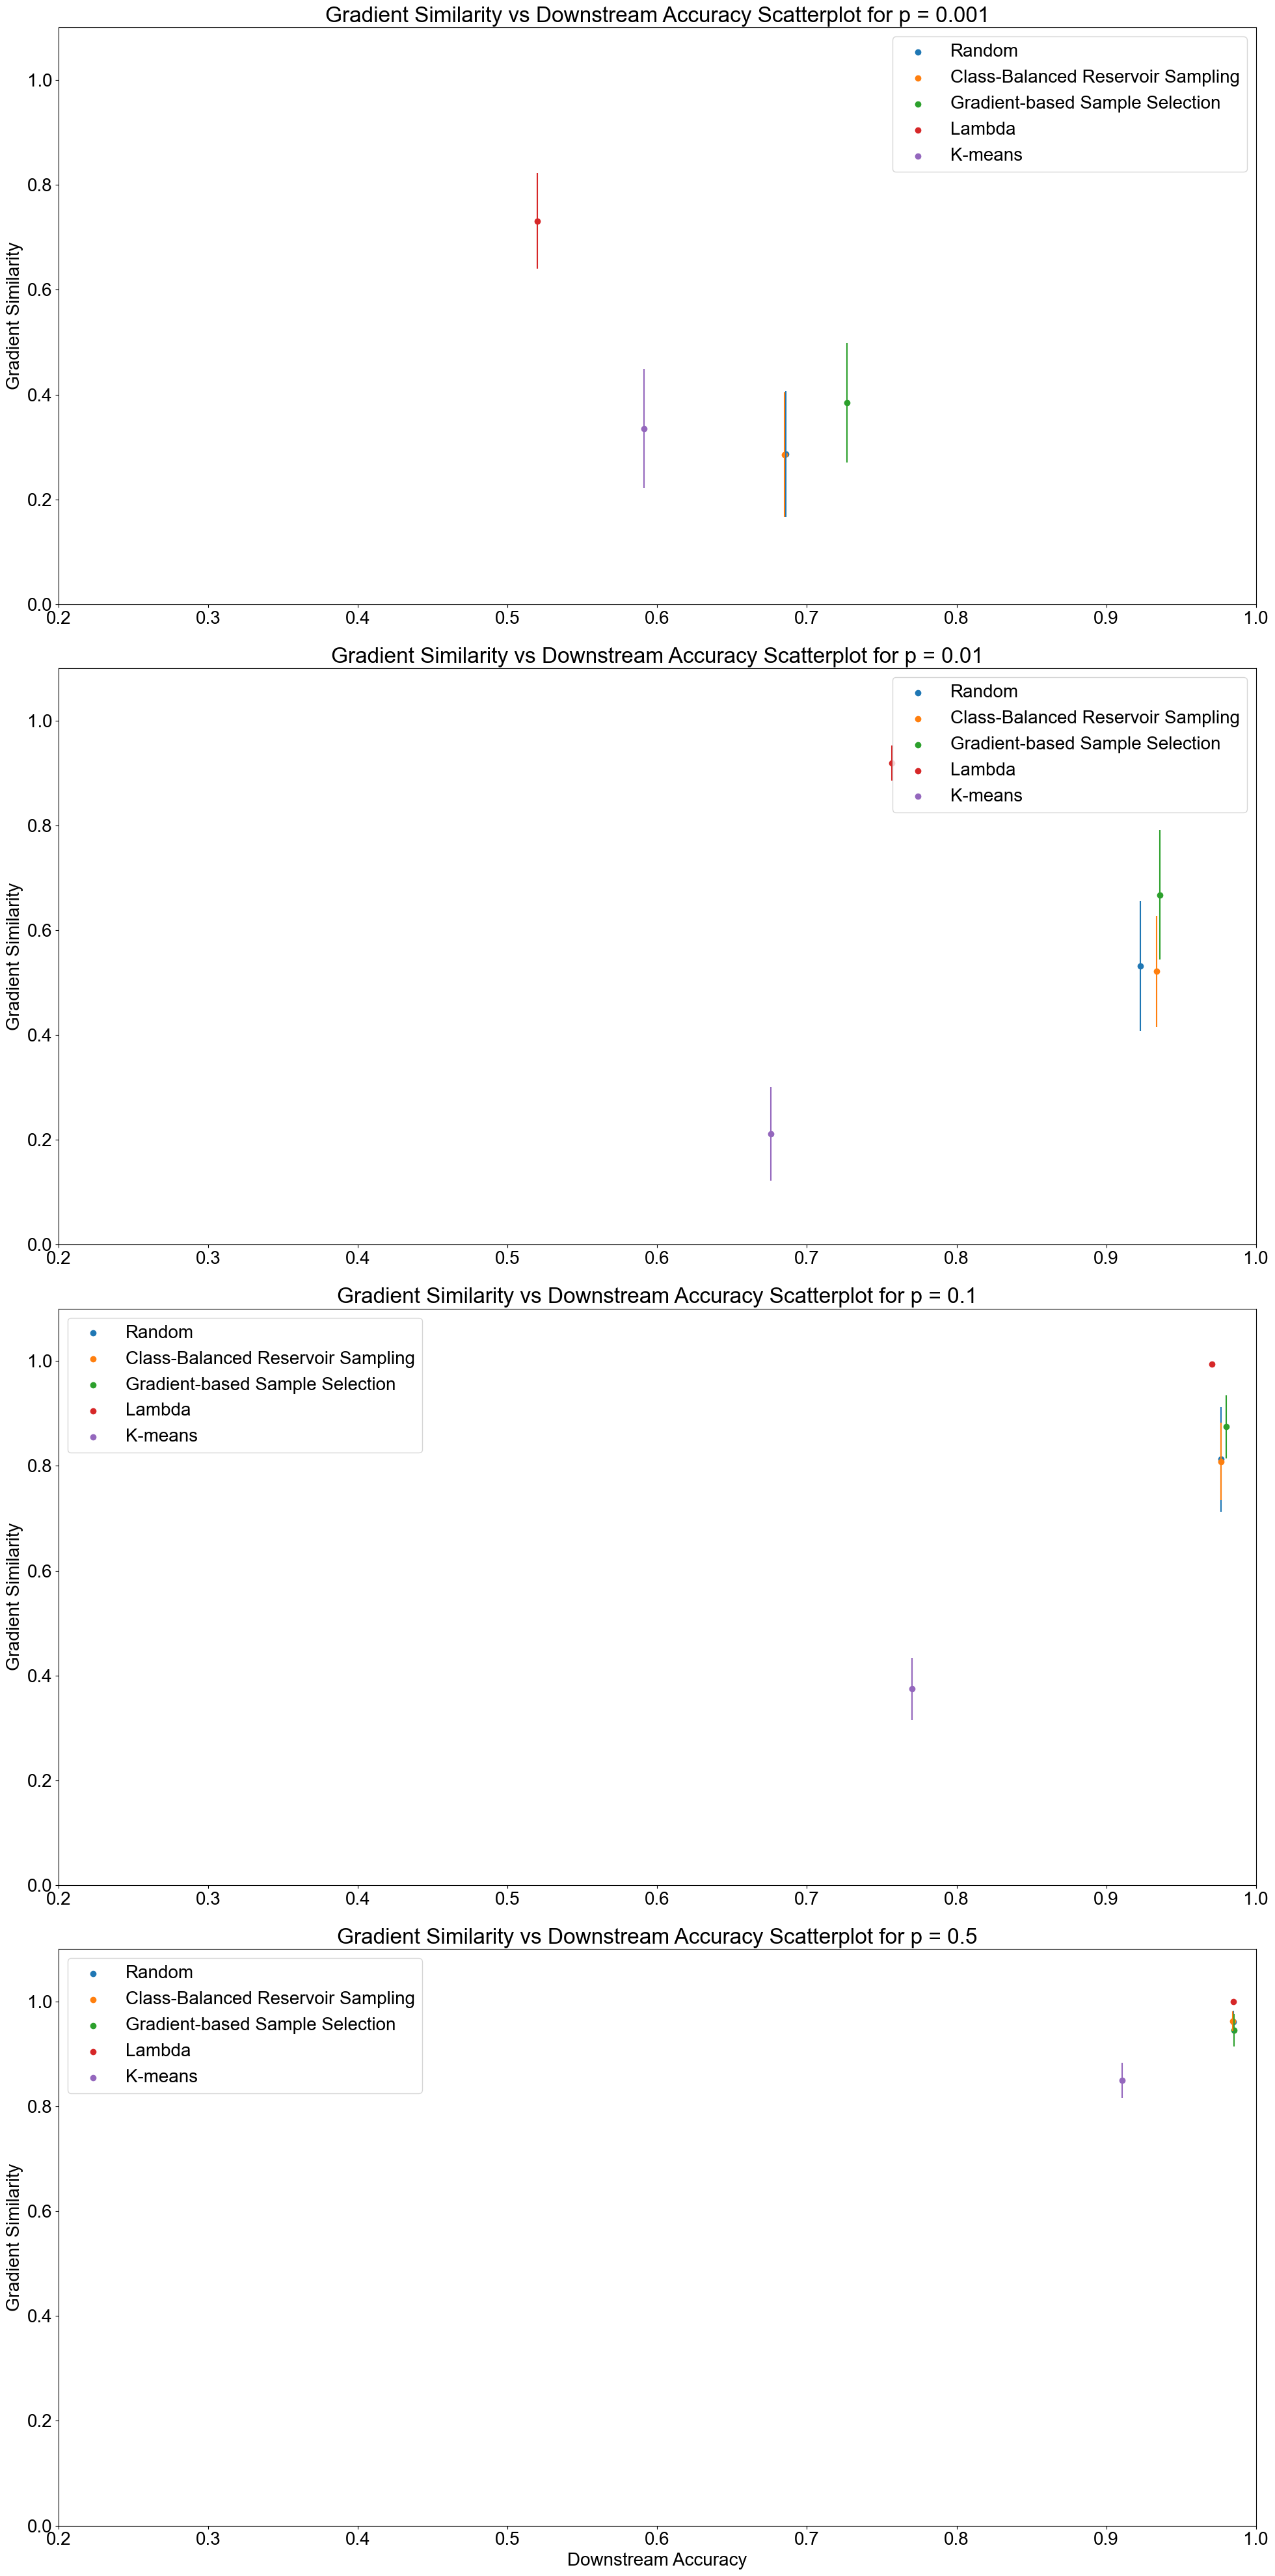

In [37]:
metric_name = 'Cosine Similarity'
p_values = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]
dataset_name = 'mnist_split'
grad_type = 'past'
method_arr = ['random', 'class_balanced', 'GSS', 'lambda', 'kmeans']
method_names = ['Random', "Class-Balanced Reservoir Sampling", "Gradient-based Sample Selection", "Lambda", "K-means"]
downstream_acc_type = 'avg' # can be last or avg
variance_type = 'all' # can be dataset, weight, or all
p_indices = [0, 3, 6, 8]

scatterplot_grad_dist(metric_name = metric_name,
               p_vals = p_values, 
               dataset_name = dataset_name, 
               grad_type = grad_type,
               method_arr = method_arr,
               method_names = method_names,
               downstream_acc_type = downstream_acc_type,
               variance_type = variance_type,
               p_indices = p_indices)

In [7]:
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

def batch_scatterplot_grad_dist(metric_name,
                   p_vals, 
                   dataset_name, 
                   grad_type,
                   method_arr,
                   method_names,
                   downstream_acc_type,
                   variance_type,
                   p_indices,
                   plot_ellipse):
    
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['font.size'] = 20
    
    result_dir = f'gradient_similarity/{dataset_name}/plots'
    if not os.path.exists(result_dir): os.mkdir(result_dir)
    
    plt.figure(figsize = (20, 10))
    ax = plt.gca()
    
    num_methods = len(method_arr)
    
    for i, p_index in enumerate(p_indices):
        
        grad_pts = np.zeros(num_methods)
        grad_vars = np.zeros(num_methods)
        accs = np.zeros(num_methods)
        
        for method_index, method in enumerate(method_arr):

            method_name = method_names[method_index]

            acc_block = np.load(f'gradient_similarity/{dataset_name}/{method}/acc_block.npy')
            # acc_block is (p_val x num_tasks) of downstream acc performance
            if downstream_acc_type == 'last':
                acc_arr = acc_block[:, -1]
            elif downstream_acc_type == 'avg':
                acc_arr = np.mean(acc_block, axis = -1)
            else:
                print('invalid downstream acc type')
                assert False

            # load gradients (num_p, num_runs, num_ideal_models, num_tasks-1, num_grad_files)
            grad_block = np.load(f'gradient_similarity/{dataset_name}/{method}/{metric_name}/{grad_type}_gradient_comp.npy')

            avg_over_grad_files = np.mean(grad_block, axis = -1)
            avg_over_tasks = np.mean(avg_over_grad_files, axis = -1)

            if variance_type == 'dataset':
                avg_grad_block = avg_over_tasks[:,:,0]
                # avg over runs
                grad_dists = np.mean(avg_grad_block, axis = -1)
                grad_stds = np.std(avg_grad_block, axis = -1)
            elif variance_type == 'weight':
                avg_grad_block = avg_over_tasks[:,0,:]
                # avg over ideal models
                grad_dists = np.mean(avg_grad_block, axis = -1)
                grad_stds = np.std(avg_grad_block, axis = -1)
            elif variance_type == 'all':
                grad_dists = np.mean(np.mean(avg_over_tasks, axis = -1), axis = -1)
                grad_stds = (np.std(avg_over_tasks[:,:,0], axis = -1)**2 + np.std(avg_over_tasks[:,0,:], axis = -1)**2)**(1/2)

            grad_pts[method_index] = grad_dists[p_index]
            grad_vars[method_index] = grad_stds[p_index]
            accs[method_index] = acc_arr[p_index]
        
        obj = ax.scatter(accs, grad_pts, label = f'p = {p_vals[p_index]}')
        if plot_ellipse:
            confidence_ellipse(accs, grad_pts, ax, n_std=1.0, edgecolor=obj.get_ec())
        else:
            plt.errorbar(accs, grad_pts, yerr = grad_vars, ls = 'none') 

    plt.xlim(0.2, 1)
    plt.ylim(0, 1.1)
    plt.title(f'Gradient Similarity vs Downstream Accuracy for Memory Selection Methods for Multiple P-values')
    plt.ylabel('Gradient Similarity')
    plt.xlabel('Downstream Accuracy')
    plt.legend(loc = 'lower left')
    if plot_ellipse:
        plt.savefig(f'{result_dir}/batch_scatterplot_ellipse.png')
    else:
        plt.savefig(f'{result_dir}/batch_scatterplot.png')
    plt.show()

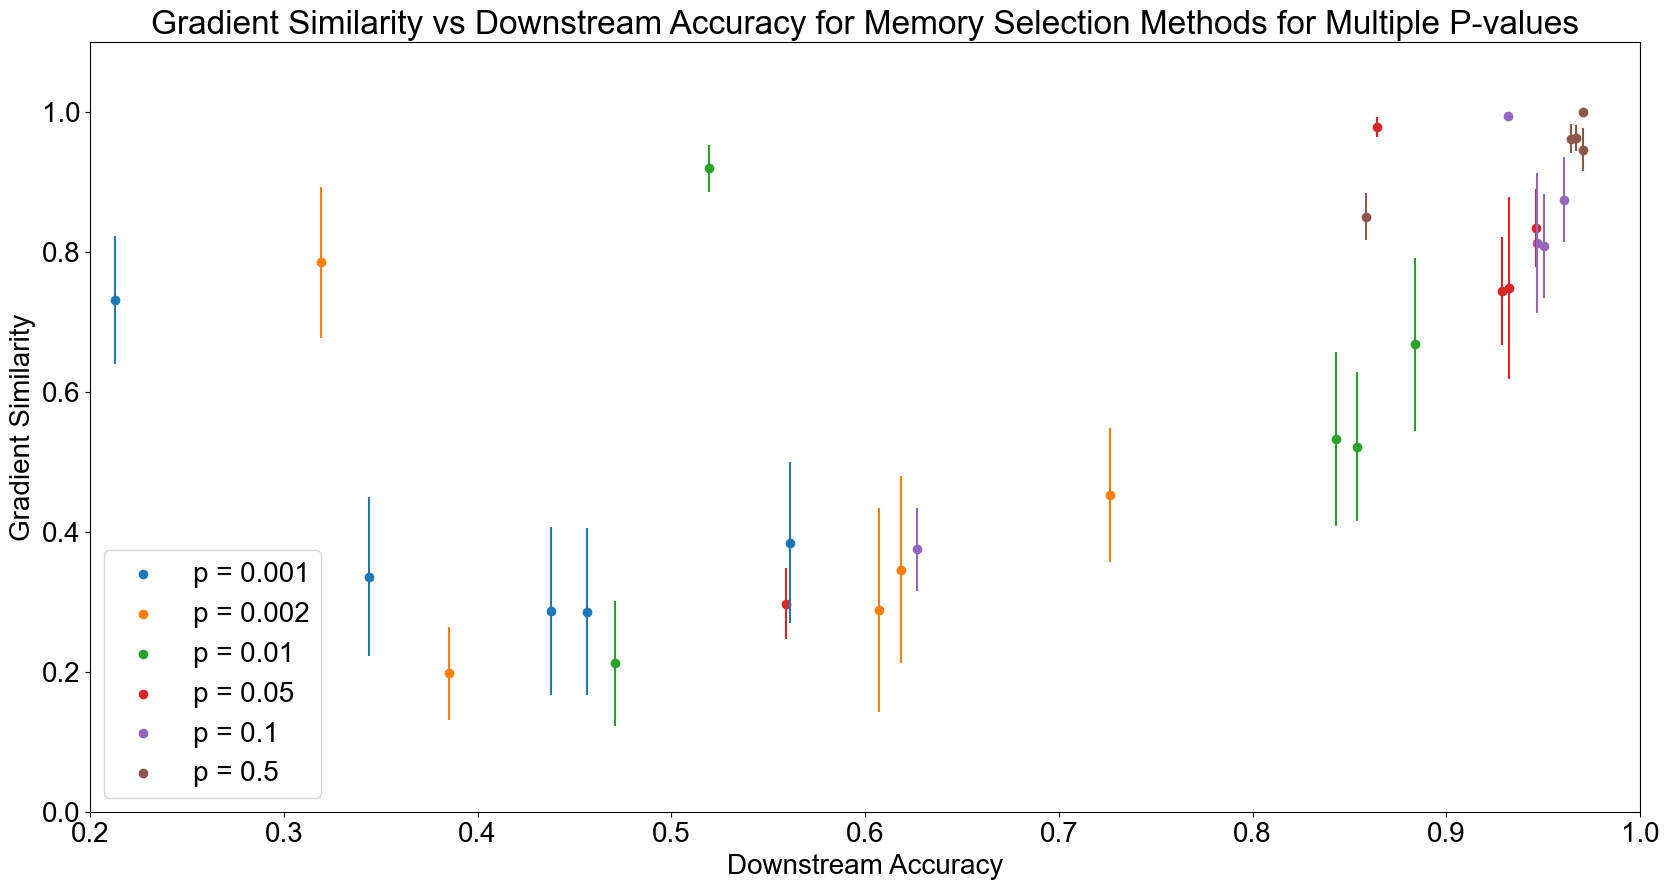

In [8]:
metric_name = 'Cosine Similarity'
p_values = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]
dataset_name = 'mnist_split'
grad_type = 'past'
method_arr = ['random', 'class_balanced', 'GSS', 'lambda', 'kmeans']
method_names = ['Random', "Class-Balanced Reservoir Sampling", "Gradient-based Sample Selection", "Lambda", "K-means"]
downstream_acc_type = 'last' # can be last or avg
variance_type = 'all' # can be dataset, weight, or all
p_indices = [0, 1, 3, 5, 6, 8]
plot_ellipse = False

batch_scatterplot_grad_dist(metric_name = metric_name,
               p_vals = p_values, 
               dataset_name = dataset_name, 
               grad_type = grad_type,
               method_arr = method_arr,
               method_names = method_names,
               downstream_acc_type = downstream_acc_type,
               variance_type = variance_type,
               p_indices = p_indices,
               plot_ellipse = plot_ellipse)

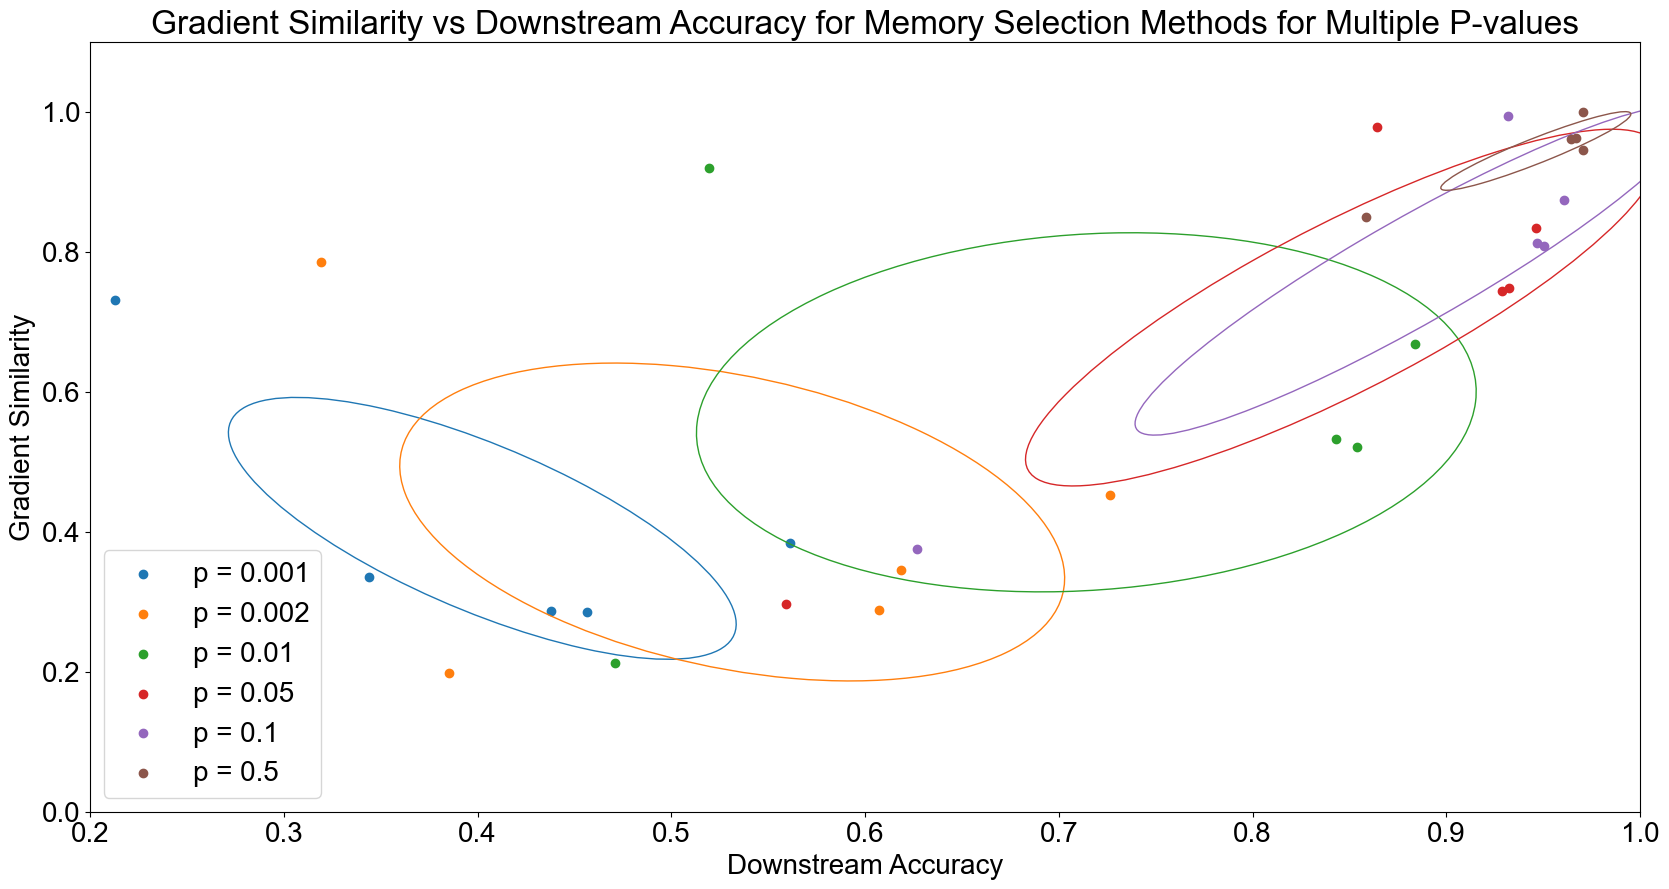

In [9]:
metric_name = 'Cosine Similarity'
p_values = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]
dataset_name = 'mnist_split'
grad_type = 'past'
method_arr = ['random', 'class_balanced', 'GSS', 'lambda', 'kmeans']
method_names = ['Random', "Class-Balanced Reservoir Sampling", "Gradient-based Sample Selection", "Lambda", "K-means"]
downstream_acc_type = 'last' # can be last or avg
variance_type = 'all' # can be dataset, weight, or all
p_indices = [0, 1, 3, 5, 6, 8]
plot_ellipse = True

batch_scatterplot_grad_dist(metric_name = metric_name,
               p_vals = p_values, 
               dataset_name = dataset_name, 
               grad_type = grad_type,
               method_arr = method_arr,
               method_names = method_names,
               downstream_acc_type = downstream_acc_type,
               variance_type = variance_type,
               p_indices = p_indices,
               plot_ellipse = plot_ellipse)

In [25]:
dataset_name = 'cifar10_split'
acc_block = np.load(f'gradient_similarity/{dataset_name}/iCaRL/acc_block.npy')
acc_block

array([[0.688     , 0.25025   , 0.24466667, 0.230625  , 0.1799    ],
       [0.96      , 0.38      , 0.294     , 0.2385    , 0.1864    ],
       [0.952     , 0.41575   , 0.29933333, 0.241125  , 0.2081    ],
       [0.946     , 0.42075   , 0.29583333, 0.241625  , 0.194     ],
       [0.9565    , 0.4205    , 0.2935    , 0.243625  , 0.2004    ],
       [0.9565    , 0.4245    , 0.29583333, 0.24325   , 0.2327    ],
       [0.959     , 0.42175   , 0.297     , 0.242625  , 0.1978    ],
       [0.9635    , 0.44625   , 0.30516667, 0.259125  , 0.1941    ],
       [0.9585    , 0.4395    , 0.2955    , 0.2485    , 0.2136    ],
       [0.957     , 0.58125   , 0.4075    , 0.328375  , 0.198     ]])

In [35]:
dataset_name = 'cifar10_split'
acc_block = np.load(f'gradient_similarity/{dataset_name}/random/acc_block.npy')
# acc_block = np.load(f'gradient_similarity/{dataset_name}/icarl/Cosine Similarity/past_gradient_comp.npy')
acc_block

array([[0.786     , 0.35825   , 0.21133333, 0.212375  , 0.2055    ],
       [0.936     , 0.4375    , 0.31716667, 0.252     , 0.2337    ],
       [0.943     , 0.5265    , 0.36733333, 0.305125  , 0.3178    ],
       [0.945     , 0.594     , 0.43733333, 0.374125  , 0.3798    ],
       [0.947     , 0.677     , 0.5005    , 0.448125  , 0.4511    ],
       [0.9515    , 0.73825   , 0.58033333, 0.5385    , 0.5243    ],
       [0.948     , 0.77575   , 0.62883333, 0.605125  , 0.5897    ],
       [0.9545    , 0.79725   , 0.66366667, 0.640125  , 0.6265    ],
       [0.9515    , 0.81375   , 0.696     , 0.672125  , 0.6583    ],
       [0.956     , 0.8185    , 0.70666667, 0.6705    , 0.6608    ]])